# Customer Segmentation & Product Recommendation System
## Data Science Internship Task 2 - Flipkart Pvt Ltd

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('C:\Users\Dell\customer_segmentation_recommendation_demo\sample_transactions.csv')
df.head()
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])
print(df.head())

  CustomerID ProductID     Category  PurchaseAmount PurchaseDate
0       C001      P001  Electronics           15000   2024-01-15
1       C002      P002      Fashion            2500   2024-01-16
2       C003      P003    Groceries             500   2024-01-17
3       C001      P002      Fashion            3000   2024-02-10
4       C004      P004  Electronics           20000   2024-02-12


### Next Steps:
- Clean data (handle missing values, data types)
- Feature engineering (RFM analysis, category preferences)
- Apply clustering (K-Means / Hierarchical)
- Build recommendation logic
- Visualize results

 Data Cleaning

In [10]:
# 1. Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# 2. Handle missing values
# - Drop rows where CustomerID or ProductID is missing (critical)
df.dropna(subset=['CustomerID','ProductID'], inplace=True)
df['PurchaseAmount'] = df['PurchaseAmount'].fillna(0)
df['Category'] = df['Category'].fillna('Unknown')

# 3. Ensure correct data types
df['CustomerID'] = df['CustomerID'].astype(str)
df['ProductID'] = df['ProductID'].astype(str)
df['Category'] = df['Category'].astype(str)
df['PurchaseAmount'] = df['PurchaseAmount'].astype(float)
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'], errors='coerce')  # coerce invalid dates

df = df.dropna(subset=['PurchaseDate'])
print("\nData types after cleaning:")
print(df.dtypes)

print("\nSample of cleaned data:")
print(df.head())


Missing values per column:
CustomerID        0
ProductID         0
Category          0
PurchaseAmount    0
PurchaseDate      0
dtype: int64

Data types after cleaning:
CustomerID                object
ProductID                 object
Category                  object
PurchaseAmount           float64
PurchaseDate      datetime64[ns]
dtype: object

Sample of cleaned data:
  CustomerID ProductID     Category  PurchaseAmount PurchaseDate
0       C001      P001  Electronics         15000.0   2024-01-15
1       C002      P002      Fashion          2500.0   2024-01-16
2       C003      P003    Groceries           500.0   2024-01-17
3       C001      P002      Fashion          3000.0   2024-02-10
4       C004      P004  Electronics         20000.0   2024-02-12


Feature Engineering

In [5]:
import datetime as dt

# Total spend
total_spend = df.groupby('CustomerID')['PurchaseAmount'].sum().reset_index(name='TotalSpend')

# Purchase frequency
purchase_count = df.groupby('CustomerID').size().reset_index(name='PurchaseCount')

# Average purchase amount
avg_purchase = df.groupby('CustomerID')['PurchaseAmount'].mean().reset_index(name='AvgPurchaseAmount')

# Recency
latest_date = df.groupby('CustomerID')['PurchaseDate'].max().reset_index()
latest_date['RecencyDays'] = (dt.datetime.now() - latest_date['PurchaseDate']).dt.days

# Preferred category
preferred_category = df.groupby(['CustomerID','Category']).size().reset_index(name='Count')
preferred_category = preferred_category.loc[preferred_category.groupby('CustomerID')['Count'].idxmax()][['CustomerID','Category']]

# Merge all
customer_profiles = total_spend.merge(purchase_count, on='CustomerID') \
                               .merge(avg_purchase, on='CustomerID') \
                               .merge(latest_date[['CustomerID','RecencyDays']], on='CustomerID') \
                               .merge(preferred_category, on='CustomerID')

print(customer_profiles)


  CustomerID  TotalSpend  PurchaseCount  AvgPurchaseAmount  RecencyDays  \
0       C001       18000              2             9000.0          609   
1       C002        2500              1             2500.0          634   
2       C003         500              1              500.0          633   
3       C004       20000              1            20000.0          607   
4       C005         700              1              700.0          604   

      Category  
0  Electronics  
1      Fashion  
2    Groceries  
3  Electronics  
4    Groceries  


Customer Segmentation

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = ['TotalSpend','PurchaseCount','AvgPurchaseAmount','RecencyDays']
X = customer_profiles[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(X_scaled)

print(customer_profiles)


  CustomerID  TotalSpend  PurchaseCount  AvgPurchaseAmount  RecencyDays  \
0       C001       18000              2             9000.0          609   
1       C002        2500              1             2500.0          634   
2       C003         500              1              500.0          633   
3       C004       20000              1            20000.0          607   
4       C005         700              1              700.0          604   

      Category  Cluster  
0  Electronics        2  
1      Fashion        0  
2    Groceries        0  
3  Electronics        1  
4    Groceries        0  


Visualization

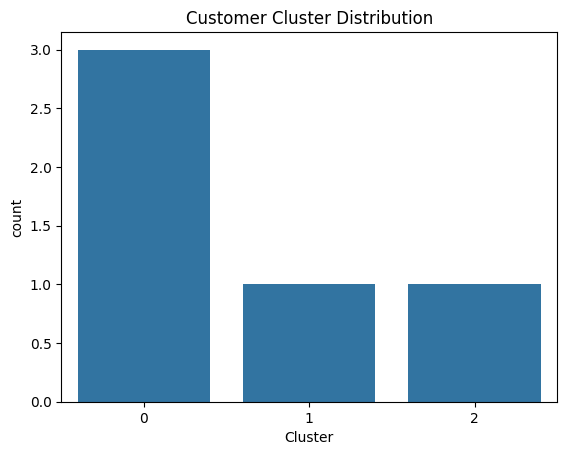

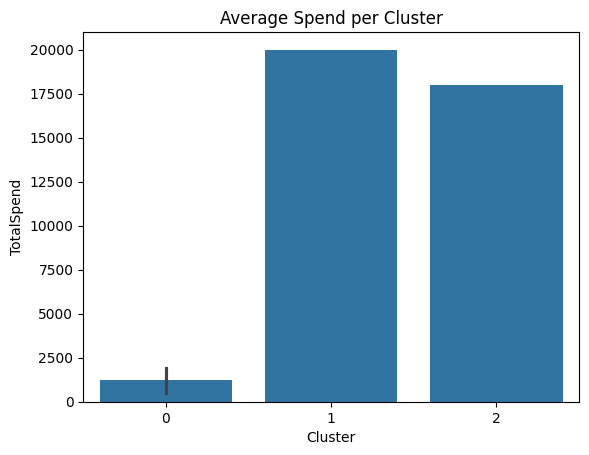

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Cluster', data=customer_profiles)
plt.title("Customer Cluster Distribution")
plt.show()

sns.barplot(x='Cluster', y='TotalSpend', data=customer_profiles)
plt.title("Average Spend per Cluster")
plt.show()


Recommendation System (Simple)

In [8]:
df_clustered = df.merge(customer_profiles[['CustomerID','Cluster']], on='CustomerID')
top_category_per_cluster = df_clustered.groupby(['Cluster','Category'])['PurchaseAmount'] \
                                      .sum().reset_index() \
                                      .sort_values(['Cluster','PurchaseAmount'], ascending=[True,False])

print(top_category_per_cluster)


   Cluster     Category  PurchaseAmount
0        0      Fashion            2500
1        0    Groceries            1200
2        1  Electronics           20000
3        2  Electronics           15000
4        2      Fashion            3000
